Semi-supervised learning of MNIST demo. 

In [1]:
# import MNIST from open ML

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# load training and test sets 

path_to_train = '/content/drive/MyDrive/Courses/AMATH482582-WIN2022/HWs/HW2/MNIST_training_set.npy'
path_to_test = '/content/drive/MyDrive/Courses/AMATH482582-WIN2022/HWs/HW2/MNIST_test_set.npy'

d_train = np.load(path_to_train, allow_pickle=True)
d_test = np.load(path_to_test, allow_pickle=True)

XX = d_train.item().get('features')
YY = d_train.item().get('labels')

print(XX.shape)
print(YY.shape)


Mounted at /content/drive
(2000, 256)
(2000,)


In [3]:
# Plot some of the training and test sets 

def plot_digits(XX, N, title):
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

In [4]:
# function to take subset of data set (ie specific digits and apply PCA transform and return)

def return_subset( dig1, dig2, dig3, XX, YY ):

  indx1 = np.argwhere( YY == dig1 )
  indx2 = np.argwhere( YY == dig2 )
  indx3 = np.argwhere( YY == dig3 )
  indx = np.append(indx1, indx2, axis=0)
  indx = np.append(indx, indx3, axis=0)
  indx = np.random.permutation(indx.flatten())

  XX_sub = XX[indx, :]
  YY_sub = YY[indx]

  # one hot encoding of classes in b 

  b = np.zeros( (len(indx), 3))

  for j in range(len(YY_sub)):
    if YY_sub[j] == dig1:
      b[j,:] = [1, 0 , 0]
    elif YY_sub[j] == dig2:
      b[j, :] = [0, 1, 0]
    elif YY_sub[j] == dig3:
      b[j, :] = [0, 0, 1] 

  return XX_sub, YY_sub, b

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


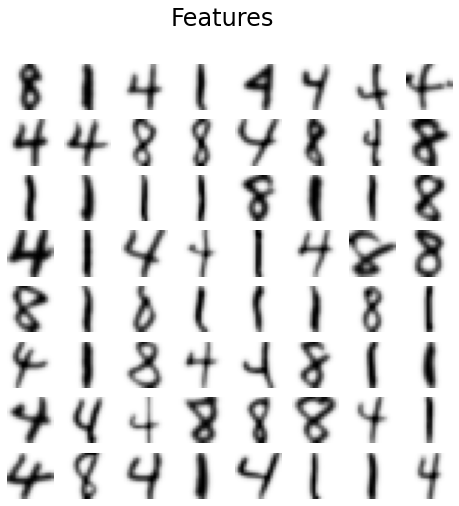

In [5]:
digit1 = 4
digit2 = 8
digit3 = 1


X, Y, hidden_labels = return_subset( digit1, digit2, digit3, XX, YY )

print(hidden_labels[0:10, :])

plot_digits( X, 8, 'Features' )


In [6]:
# We only observe the first M labels 

M = 10

labels = hidden_labels[0:M, :]

print(labels.shape)
print(hidden_labels.shape)

print(labels)


(10, 3)
(652, 3)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


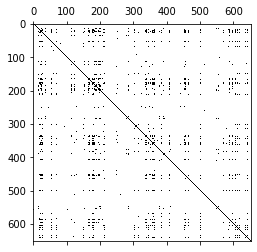

In [29]:
# construct graph Laplacian on features

import scipy as sp
import scipy.spatial

dist = sp.spatial.distance_matrix( X, X )

def eta(t, l):

  val = np.exp(-(1/(2*l**2))*t**2 )

  return val

# l length scale of the kernel 

l = 0.05*dist.mean()

W = eta(dist, l)

plt.spy(W>= 1e-4)

In [ ]:
D = np.diag(np.sum(W,axis=1))

L = D - W 

# compute eigendecompositions 

ll, VV = np.linalg.eigh(L)

# we need to sort the eigenvalues and vectors 

idx = ll.argsort()
l = ll[idx]
V = VV[:, idx]

K = M # number of eigenvectors to use to approximate the classifier on labelled set

Vp = V[0:M, 0:K]


In [23]:
# Ridge regression on labelled set 

from sklearn.linear_model import Ridge

SSLRidge = Ridge(alpha = 1e-8)

SSLRidge.fit( Vp, labels )

beta = np.zeros((K+1,3)) # we have three classes so beta is now a matrix

beta[0, :] = SSLRidge.intercept_

beta[1:None, :] = np.transpose(SSLRidge.coef_)

In [24]:
# predict labels on entire graph 

A = np.append( np.ones( (len(Y), 1) ), V[:, 0:K], axis =1 )

labels_pred = np.dot(A, beta)

classes_pred = np.argmax(labels_pred, axis= 1)

print(A.shape)


(652, 11)


[[6.52020662e-01 1.15993080e-01 2.31986258e-01]
 [6.52020517e-01 1.15993129e-01 2.31986355e-01]
 [6.52020527e-01 1.15993125e-01 2.31986348e-01]
 [6.52020517e-01 1.15993129e-01 2.31986355e-01]
 [7.82742282e-01 7.24194975e-02 1.44838220e-01]
 [6.52020510e-01 1.15993131e-01 2.31986359e-01]
 [6.53214704e-01 1.15595069e-01 2.31190227e-01]
 [9.99898854e-01 3.37127031e-05 6.74337583e-05]
 [6.52020456e-01 1.15993149e-01 2.31986395e-01]
 [6.52020972e-01 1.15992977e-01 2.31986051e-01]
 [6.52020580e-01 1.15993108e-01 2.31986312e-01]
 [6.52020553e-01 1.15993117e-01 2.31986331e-01]
 [6.52001984e-01 1.15999306e-01 2.31998709e-01]
 [6.52020582e-01 1.15993107e-01 2.31986311e-01]
 [6.52020513e-01 1.15993130e-01 2.31986357e-01]
 [6.54281813e-01 1.15239368e-01 2.30478819e-01]
 [6.52020517e-01 1.15993129e-01 2.31986355e-01]
 [6.52020517e-01 1.15993129e-01 2.31986355e-01]
 [6.52020517e-01 1.15993129e-01 2.31986355e-01]
 [6.52020517e-01 1.15993129e-01 2.31986355e-01]]


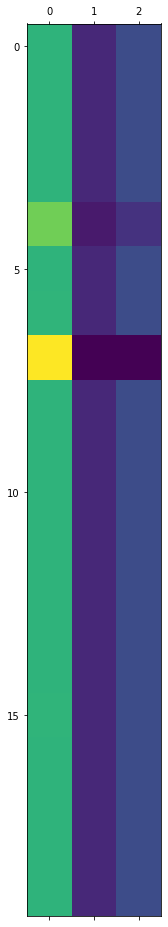

In [25]:
plt.matshow(labels_pred[0:20, :])

print(labels_pred[0:20,:])

In [26]:
# threshold predicted labels to one-hot format
labels_pred_max = np.amax(labels_pred, axis=1)

print(labels_pred_max.shape)

import numpy.matlib

labels_pred_max = np.transpose(np.matlib.repmat(labels_pred_max, 3, 1))

(652,)


Text(0.5, 1.05, 'Predicted labels')

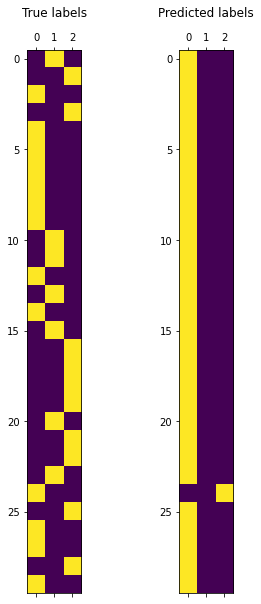

In [27]:
labels_pred_thresholded = (labels_pred == labels_pred_max).astype(float)

fig, ax = plt.subplots(1, 2, figsize=(5, 10))

ax[0].matshow(hidden_labels[0:30, :])
ax[0].set_title('True labels')

ax[1].matshow(labels_pred_thresholded[0:30, :])
ax[1].set_title('Predicted labels')

In [28]:
# compute percentage of mislabelled images 

err = 0

print(hidden_labels.shape)
print(labels_pred_thresholded.shape)


for i in range(len(hidden_labels)):
  # count number of mislabelled images 
  err+= 1- np.array_equal( hidden_labels[i,:], labels_pred_thresholded[i, :])

mislabelled_ratio = err/len(hidden_labels)

print('mislablled ratio:', mislabelled_ratio)

(652, 3)
(652, 3)
mislablled ratio: 0.7116564417177914
